In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing

from src.nnpehgp import NNPEHGP

In [2]:
def f1(X, add_noise=False):
    target = X * np.sin(X) + np.sqrt(16*X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 1, size=target.shape)
    return target.squeeze()

f2 = np.cos
transform = np.exp

# Test Data

In [3]:
X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)

# Compute loc and scale as functions of input X
loc = f1(X, add_noise=False).reshape(-1,1)
scale = transform(f2(X))

# Sample outputs Y from Gaussian Likelihood
Y = np.random.normal(loc, scale)

# Training Data

In [4]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 10, size=25).reshape(-1, 1)
mean_train = f1(X_train, add_noise=False).reshape(-1,1)
scale_train = transform(f2(X_train))

np.random.seed(17)
y_train = np.random.normal(mean_train, scale_train)

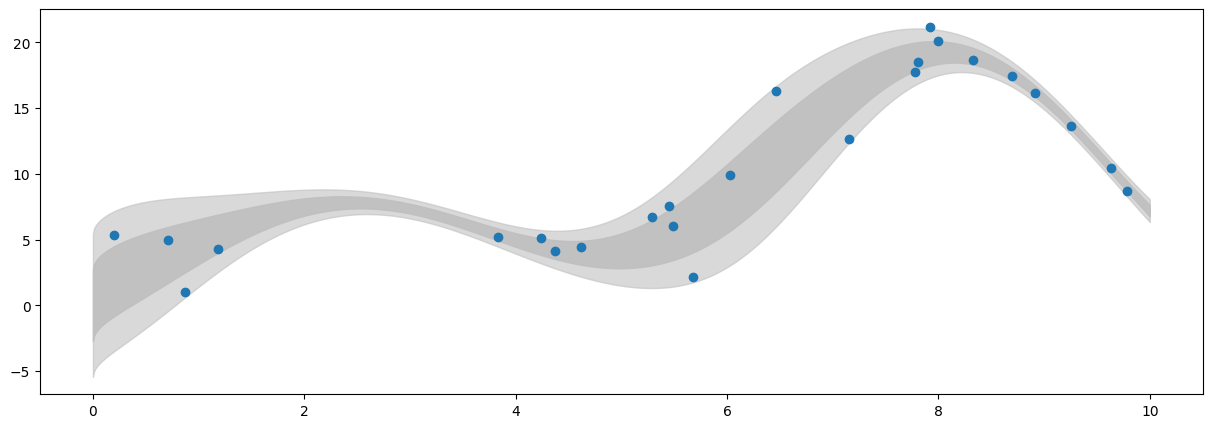

In [5]:
plt.figure(figsize=(15, 5))
x = X.squeeze()
for k in (1, 2):
    lb = (loc - k * scale).squeeze()
    ub = (loc + k * scale).squeeze()
    plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
plt.scatter(X_train, y_train)

# Improved Most Likely Heteroscedastic Gaussian Process approach

In [6]:
# Normalize X
normalizer = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_norm = normalizer.transform(X)

# define the model
kernel = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-2, 1e1)
)
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) +  WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-2, 1e2)
)

model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
model_noise = GaussianProcessRegressor(kernel=kernel_noise, n_restarts_optimizer=25)

hgp = NNPEHGP(model, model_noise, v=2, k=6)

# fit the model
hgp.fit(X_train_norm, y_train.flatten())

# make a prediction 
Y_pred, Std_pred = hgp.predict(X_norm, return_std="multi")

std_al, std_ep = Std_pred
std_tot = np.sqrt(std_al**2 + std_ep**2)

/Users/fazaghifari/miniconda3/envs/raenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Text(0, 0.5, 'z')

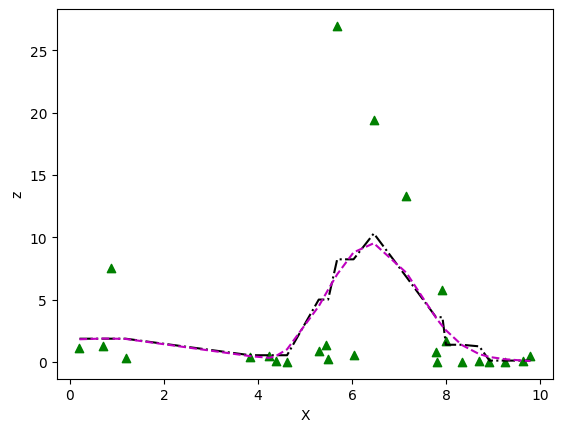

In [7]:
sorted_xtrain = np.sort(X_train, axis=0)
sorted_xtrain_norm = np.sort(X_train_norm, axis=0)
plt.scatter(X_train, (hgp.z), marker="^", color="green")
plt.plot(sorted_xtrain, (hgp.model_knn.predict(sorted_xtrain_norm)), "-.k")
plt.plot(sorted_xtrain, (hgp.model_noise.predict(sorted_xtrain_norm)), "--m")
plt.xlabel("X")
plt.ylabel("z")

In [8]:
hgp.model_noise.kernel_

3.79**2 * RBF(length_scale=0.446) + WhiteKernel(noise_level=0.386)

In [9]:
hgp.model.kernel_

9.22**2 * RBF(length_scale=0.721) + WhiteKernel(noise_level=0.01)

In [10]:
np.max(std_al)

3.0875571492258964

In [11]:
np.max(std_al)

3.0875571492258964

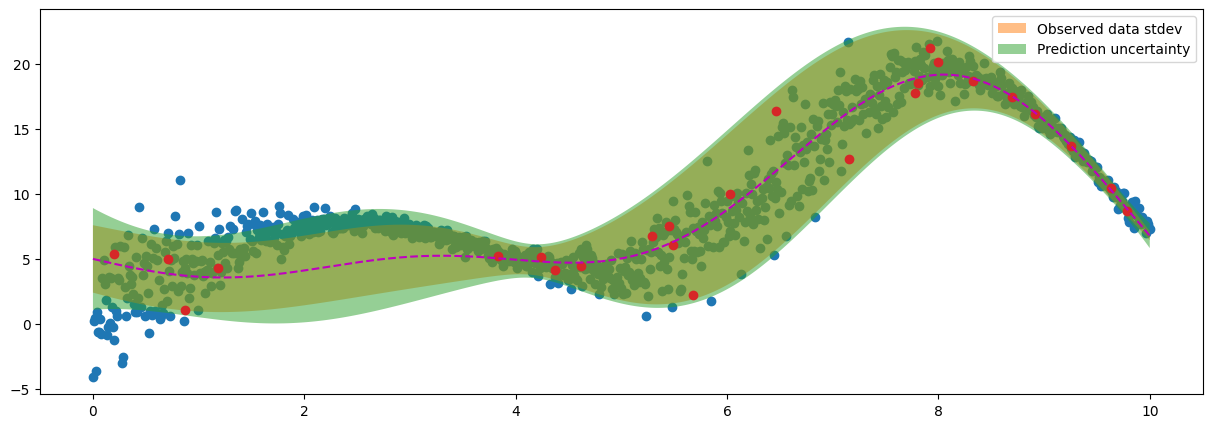

In [12]:
plt.figure(figsize=(15, 5))
plt.scatter(X,Y)
x = X.squeeze()
plt.fill_between(
    X.ravel(),
    Y_pred - 1.96 * (std_al),
    Y_pred + 1.96 * (std_al),
    alpha=0.5,
    label=r"Observed data stdev",
)
plt.fill_between(
    X.ravel(),
    Y_pred - 1.96 * std_tot,
    Y_pred + 1.96 * std_tot,
    alpha=0.5,
    label=r"Prediction uncertainty",
)
plt.plot(X, Y_pred, "--m")
plt.scatter(X_train, y_train)
plt.legend()

In [13]:
np.exp(hgp.model.kernel_.theta)

array([0.01])

In [14]:
hgp.model.kernel_

9.22**2 * RBF(length_scale=0.721) + WhiteKernel(noise_level=0.01)

In [15]:
X_train.shape

(25, 1)